# KEYS Take Away

- Structure of ARIMA
  +  Mô hình được áp dụng trên các chuỗi đặc thù có yếu tố thời gian. Một mô hình chuỗi thời gian thường dự báo dựa trên giả định rằng các qui luật trong quá khứ sẽ lặp lại ở tương lai. Chúng ta đang mô hình hóa mối quan hệ trong quá khứ giữa biến độc lập (biến đầu vào) và biến phụ thuộc (biến mục tiêu). Dựa vào mối quan hệ này để dự đoán giá trị trong tương lai của biến phụ thuộc.<br>
  <br>
  + Những qui luật đặc trưng như : yếu tố chu kỳ, mùa vụ và yếu tố xu hướng.
  <br>
  
  + Trend
  + Seasonality
  + Cyclicality(repeating pattern but no fixed period)
  + White nose(series of measurement, where each value is uncorrelated with previous value - ex:flipping coin)
  + Stationarity(distribution of data doesn't change with time). 3 criteria to fulfill:
      - zero trend, isn't growing or shrinking
      - variance is constant (the avg distance of data points from zero line isnt changing)
      - autocorrelation is constant (how each value in time series related to its neighbors stays the same)

  + Making time series stationary
      - augemented dicky_fuller test if our time series is non-stationary
      - Split dataset
  

<br> - Fit ARIMA model
<br> - Optimize model
- Make forecasts
- Calculate Uncertainty in predictions


# Libraries

In [25]:
!pip install pmdarima

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima #func to compute sarima model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from math import sqrt
from pandas import concat
from datetime import datetime
from matplotlib import pyplot
from numpy import concatenate, asarray
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import warnings
# Ignore all warnings
warnings.filterwarnings('ignore')


# COFFEE Data

#Read coffee data & preprocessing data
coffee_df = pd.read_excel('coffee_data.xlsx',index_col='Ngày',
            parse_dates= ['Ngày'])

# Resample to daily frequency and forward-fill missing values
coffee_df = coffee_df.resample('D').ffill()
# Reset the index
coffee_df = coffee_df.reset_index()

coffee_df

coffee_df.head()

#Trend
fig, ax = plt.subplots(figsize=(12, 10))
coffee_df.plot(ax=ax)
plt.xlabel('Ngày')
plt.ylabel('Giá Cà Phê')
plt.title('Coffee Price Trend')
plt.show()

# Feature engineering 

In [27]:
#import and read new data file with pre-processing steps: 'data.xlsx'
data_df = pd.read_excel('veg_data.xlsx',index_col='Ngày',
            parse_dates= ['Ngày'])

## Khởi tạo chuỗi lợi suất và khảo sát dữ liệu

In [28]:
data_df

,Giá Cà Phê,Giá Diesel 1 lít,Precipitation (mm),Temperature (°C)
Ngày,,,,
2021-01-01,31667.5,12640,1174.199994,24.937842
2021-01-02,31667.5,12640,1174.199994,24.937842
2021-01-03,31667.5,12640,1174.199994,24.937842
2021-01-04,32717.0,12640,1174.199994,24.937842
2021-01-05,32417.0,12640,1174.199994,24.937842
...,...,...,...,...
2023-04-06,49766.5,20140,1259.800013,24.170057
2023-04-07,49566.5,20140,1259.800013,24.170057
2023-04-08,49566.5,20140,1259.800013,24.170057


In [29]:
# Calculate the logarithmic return
r_t = np.log(data_df['Giá Cà Phê'] / data_df['Giá Cà Phê'].shift(1))

scaler_diesel_price = StandardScaler()
scaled_diesel_price = scaler_diesel_price.fit_transform(data_df[['Giá Diesel 1 lít']])

scaler_precipitation = MinMaxScaler()
scaled_precipitation = scaler_precipitation.fit_transform(data_df[['Precipitation (mm)']])


#scaler_temp = MinMaxScaler()
scaler_temp = StandardScaler()
scaled_temp = scaler_temp.fit_transform(data_df[['Temperature (°C)']])

0s zero in the entire 2 features column 
-> It likely indicates that the values in these columns are not changing much or are very close to each other between consecutive time points. In such cases, calculating the logarithmic return might not be suitable since it can lead to division by zero or produce very small values that approximate to zero.

In [30]:
# Create a DataFrame for the return series
returns_df = pd.DataFrame({'r_coffee_price': r_t,})

In [31]:
# Concatenate the scald columns to the dataframe
returns_df['scaled_diesel_price'] = scaled_diesel_price
returns_df['scaled_precipitation'] = scaled_precipitation
returns_df['scaled_temp'] = scaled_temp

In [32]:
returns_df

,r_coffee_price,scaled_diesel_price,scaled_precipitation,scaled_temp
Ngày,,,,
2021-01-01,NaN,-1.670519,0.000000,1.124032
2021-01-02,0.000000,-1.670519,0.000000,1.124032
2021-01-03,0.000000,-1.670519,0.000000,1.124032
2021-01-04,0.032604,-1.670519,0.000000,1.124032
2021-01-05,-0.009212,-1.670519,0.000000,1.124032
...,...,...,...,...
2023-04-06,0.006046,0.066395,0.679365,-1.083780
2023-04-07,-0.004027,0.066395,0.679365,-1.083780
2023-04-08,0.000000,0.066395,0.679365,-1.083780


In [33]:
#Fill giá trị np.nan bằng trung bình chuỗi.
mean = np.nanmean(r_t)
r_t[0]=mean
r_t[:5]

Ngày
2021-01-01    0.000546
2021-01-02    0.000000
2021-01-03    0.000000
2021-01-04    0.032604
2021-01-05   -0.009212
Name: Giá Cà Phê, dtype: float64

In [34]:
returns_df['r_coffee_price'] = r_t

In [35]:
returns_df

,r_coffee_price,scaled_diesel_price,scaled_precipitation,scaled_temp
Ngày,,,,
2021-01-01,0.000546,-1.670519,0.000000,1.124032
2021-01-02,0.000000,-1.670519,0.000000,1.124032
2021-01-03,0.000000,-1.670519,0.000000,1.124032
2021-01-04,0.032604,-1.670519,0.000000,1.124032
2021-01-05,-0.009212,-1.670519,0.000000,1.124032
...,...,...,...,...
2023-04-06,0.006046,0.066395,0.679365,-1.083780
2023-04-07,-0.004027,0.066395,0.679365,-1.083780
2023-04-08,0.000000,0.066395,0.679365,-1.083780


In [36]:
#Bieu do loi suat
r_coffee_price = returns_df['r_coffee_price']

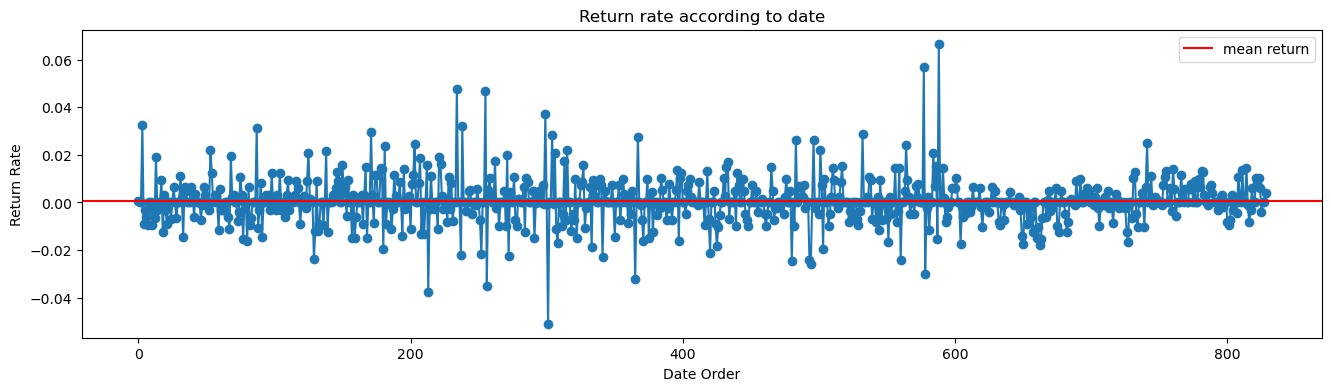

In [37]:
plt.figure(figsize=(16, 4))
plt.plot(np.arange(r_coffee_price.shape[0]), r_coffee_price, '-o')
plt.axhline(y=mean, label='mean return', c='red')
plt.title('Return rate according to date')
plt.xlabel('Date Order')
plt.ylabel('Return Rate')
plt.legend()
plt.show()

In [38]:
# Nhan xet: 

In [39]:
# Quan he tuyen tinh giua rt va rt-1

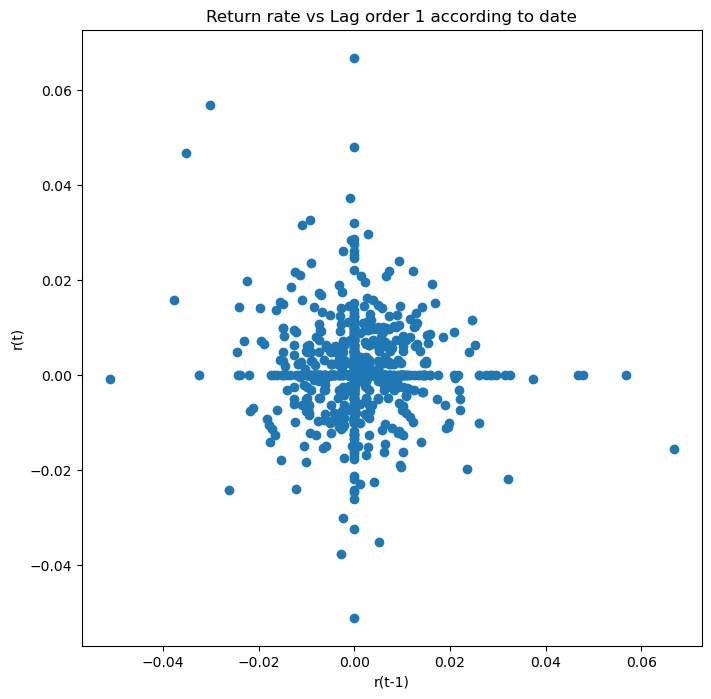

In [40]:
plt.figure(figsize=(8, 8))
plt.scatter(x=r_coffee_price[1:], y=r_coffee_price[:-1])
plt.title('Return rate vs Lag order 1 according to date')
plt.xlabel('r(t-1)')
plt.ylabel('r(t)')
plt.show()

Text(0, 0.5, 'frequency')

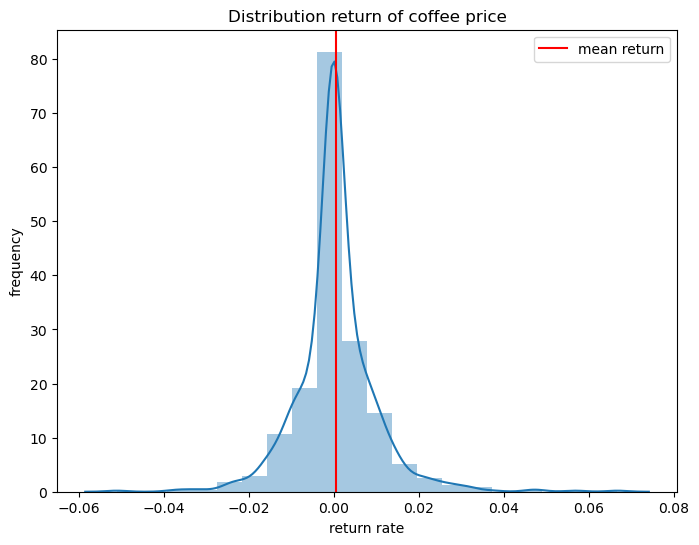

In [41]:
import seaborn as sns

plt.figure(figsize = (8, 6))
sns.distplot(r_coffee_price, bins = 20)
plt.axvline(x=mean, label='mean return', c='red')
plt.title('Distribution return of coffee price')
plt.legend()
plt.xlabel('return rate')
plt.ylabel('frequency')

Từ biểu đồ ta kết luận 2 chuỗi có phân phối tương tự nhau nếu như các điểm trên đồ thì nằm trên một đường thẳng. Khi đó 
có thể được coi như là một phân phối chuẩn. Cách kiểm định phân phối chuẩn dựa trên biểu đồ qqplot

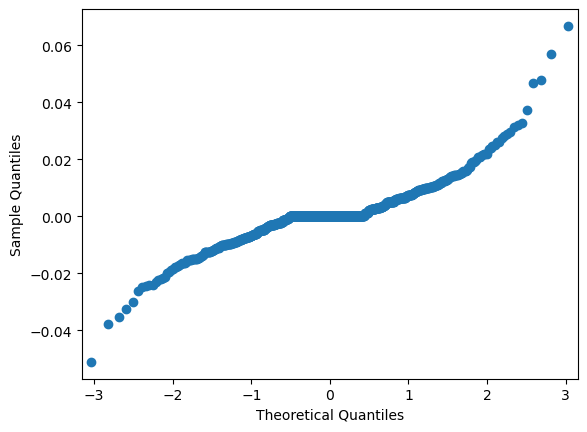

In [42]:
#c1
import statsmodels.api as sm
sm.qqplot(r_coffee_price)
plt.show()

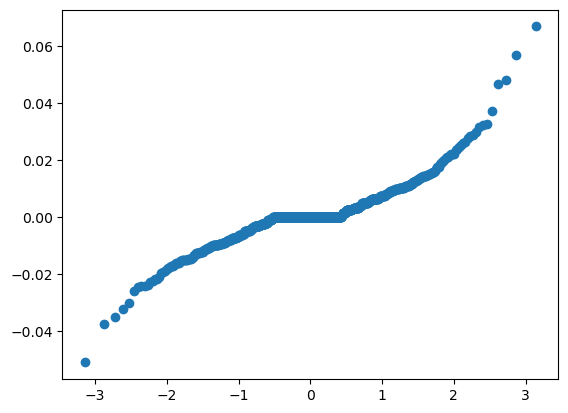

In [43]:
#c2
from scipy import stats
tq = stats.probplot(r_coffee_price)
plt.scatter(x=tq[0][0], y = tq[0][1])
plt.show()

## Kiểm tra tính dừng (stationarity?)

In [44]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(r_coffee_price)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
    
#0th element test statistic: -27
    # more negative means more likely to be stationary
    
#1st element is test p-value: 0.
    # if p-value is < 0.05 -> reject null hypothesis -> reject non-stationary -> must be stationary
    
#4th element is the critical test statistics (dictionary) equate to different p-values
    # if we wanted a p-value of 0.05 or below, our test statistic needed to be below -2.86

ADF Statistic: -22.304609
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


# Xây dựng mô hình

<Figure size 800x600 with 0 Axes>

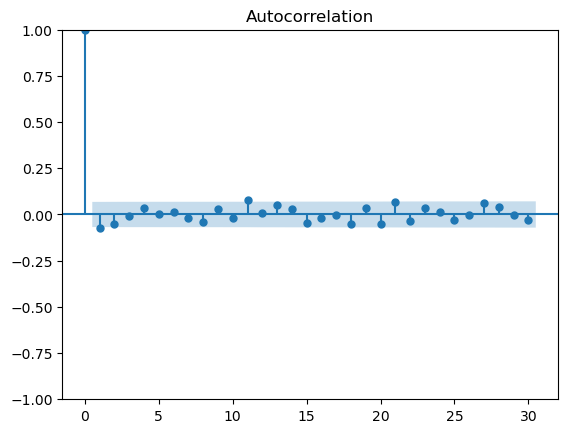

In [45]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 6))
ax1 = plot_acf(r_coffee_price)

Đối với bài toán này toàn bộ các hệ số tự tương quan với bậc nhỏ hơn hoặc bằng 5 đều có giá trị nằm trong khoảng tin cậy 95% của 0. Do đó chúng ta có thể linh hoạt lựa chọn bậc *q* = 5
 là vị trí mà hệ số tự tương quan lớn nhất.

<Figure size 800x600 with 0 Axes>

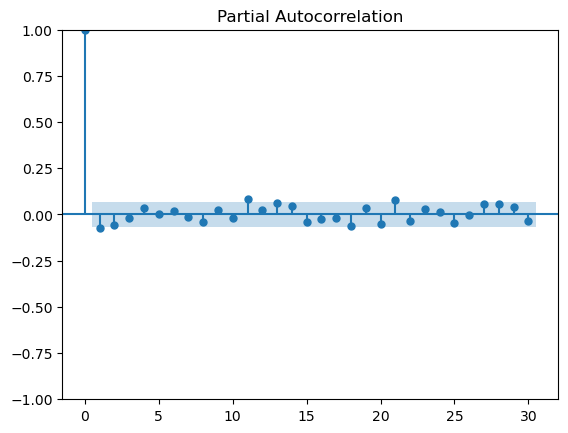

In [46]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 6))
ax2 = plot_pacf(r_coffee_price)

PACF sẽ có tác dụng tìm ra hệ số bậc tự do *p*
 của quá trình tự hồi qui *AR(p)*
. Tương tự như ACF, thông qua một biểu đồ PACF về giá trị các hệ số tương quan riêng phần tương ứng với các độ trễ khác nhau, chúng ta sẽ tìm ra được các bậc tự do *p*
 phù hợp. Đó chính là vị trí mà giá trị của hệ số tương quan riêng phần nằm ngoài ngưỡng tin cậy 95% của giả thuyết hệ số tương quan riêng phần bằng 0.

Tương tự như ACF, bậc của PACF cũng thường nhỏ hơn 5. Như vậy ta cũng có thể lựa chọn bậc tự do của PACF là một giá trị nào đó từ 1 đến 5. Kết hợp giữa bậc của *p*
 và *q*
 và giá trị của *d = 0*
 do chuỗi *rt* 
 đã là một chuỗi dừng ta có thể thu được một số kịch bản

ARIMA(2, 0, 2)
ARIMA(2, 0, 0)
ARIMA(5, 0, 0)
ARIMA(0, 0, 5)

# Chỉ số AIC - Akaike Information Criteria
- giá trị của AIC càng nhỏ thì mô hình của chúng ta càng phù hợp.

## Đọc hiểu kết quả mô hình ARIMA.

In [47]:
from statsmodels.tsa.arima.model import ARIMA

def _arima_fit(orders, data):
  models = dict()
  for order in orders:
    model = ARIMA(data, order = order).fit()
    model_name = 'ARIMA({},{},{})'.format(order[0], order[1], order[2])
    print('{} --> AIC={}; BIC={}'.format(model_name, model.aic, model.bic))
    models[model_name] = model
  return models

In [48]:
r_coffee_price

Ngày
2021-01-01    0.000546
2021-01-02    0.000000
2021-01-03    0.000000
2021-01-04    0.032604
2021-01-05   -0.009212
                ...   
2023-04-06    0.006046
2023-04-07   -0.004027
2023-04-08    0.000000
2023-04-09    0.000000
2023-04-10    0.004027
Name: r_coffee_price, Length: 829, dtype: float64

In [49]:
orders = [(2, 0, 2), (2, 0, 0), (5, 0, 0), (0, 0, 5)]
models = _arima_fit(orders, r_coffee_price)

ARIMA(2,0,2) --> AIC=-5368.244701096124; BIC=-5339.923380165313
ARIMA(2,0,0) --> AIC=-5371.869491817315; BIC=-5352.9886111967735
ARIMA(5,0,0) --> AIC=-5367.012301350871; BIC=-5333.970760264924
ARIMA(0,0,5) --> AIC=-5367.1420269846; BIC=-5334.1004858986535


Ta nhận thấy mô hình ARIMA(2,0,0) là phù hợp nhất với bộ dữ liệu lợi suất vì nó tương ứng với chỉ số AIC là nhỏ nhất.

## Phương pháp Auto ARIMA

In [50]:
model = auto_arima(r_coffee_price, start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

print(model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-5367.695, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-5369.872, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-5370.349, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-5368.956, Time=0.19 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-5370.225, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-5368.222, Time=0.27 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-5371.617, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-5368.444, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-5370.065, Time=0.61 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-5371.834, Time=0.42 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-5369.837, Time=0.50 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-5369.844, Time=0.43 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-5367.887, Time=0.45 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0] intercept
Total fit time: 3.904 seconds
-5371.834

Trong trường hợp mô hình có yếu tố mùa vụ thì ta sẽ cần thiết lập seasonal = True và kết hợp thêm chu kì của mùa vụ. Chẳng hạn chu kì là 7 ngay thì có thể khai báo D = 7. Khi đó mô hình ARIMA sẽ trở thành mô hình SARIMA (seasonal ARIMA).
<br>
<br>Kết quả mô hình tốt nhất thu được là ARIMA(0, 0, 2):

In [51]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  829
Model:               SARIMAX(0, 0, 2)   Log Likelihood                2689.917
Date:                Wed, 20 Sep 2023   AIC                          -5371.834
Time:                        15:10:27   BIC                          -5352.953
Sample:                             0   HQIC                         -5364.593
                                - 829                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.000      1.804      0.071   -4.72e-05       0.001
ma.L1         -0.0763      0.029     -2.592      0.010      -0.134      -0.019
ma.L2         -0.0514      0.029     -1.772      0.076      -0.108       0.005
sigma2      8.895e-05   2.23e-06     39.917      0.000    8.46e-05    9.33e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2010.55
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                             0.84
Prob(H) (two-sided):                  0.02   Kurtosis:                        10.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

 # Kiếm tra yếu tố mùa vụ

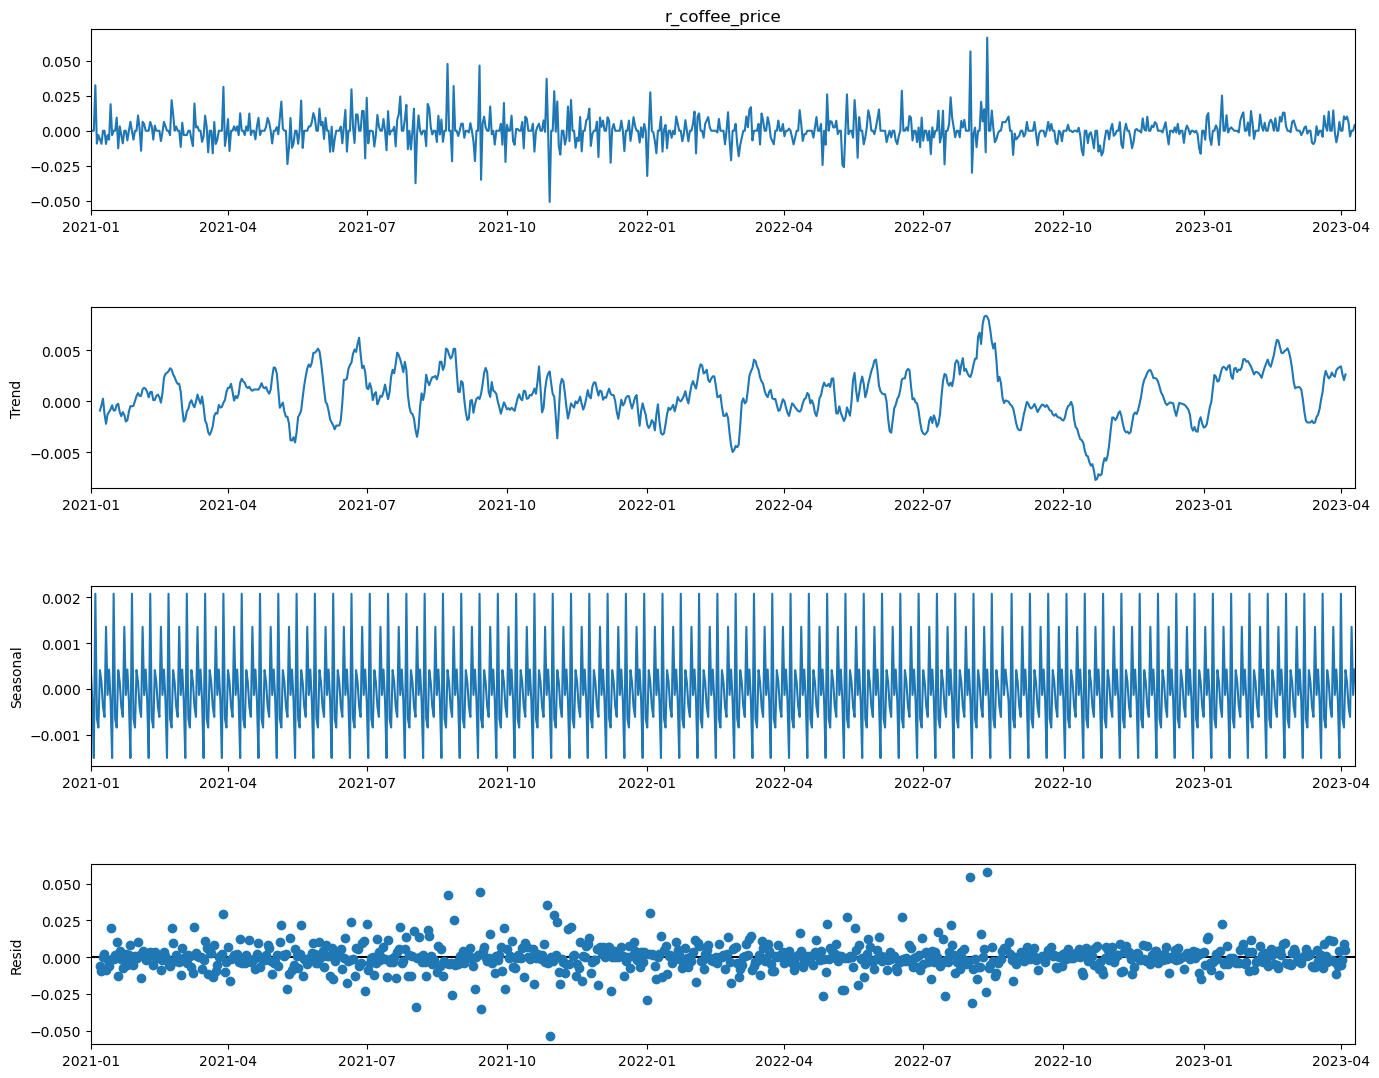

In [52]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(r_coffee_price, period = 12)
fig = result.plot()
fig.set_size_inches(16, 12)

# ---------- Split data ----------

In [53]:
#training and test set
training = returns_df.iloc[:-31]  # Up to 31 days before the end of the data
testing = returns_df.iloc[-31:]  # Last 31 days of the data

In [54]:
training.shape

(798, 4)

In [55]:
testing.shape

(31, 4)

In [56]:
coffee_price = training['r_coffee_price'] 

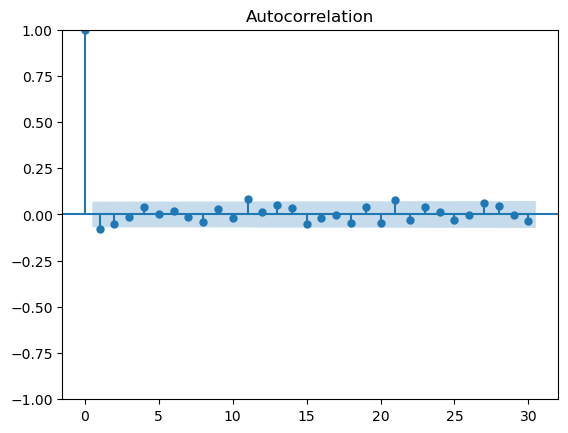

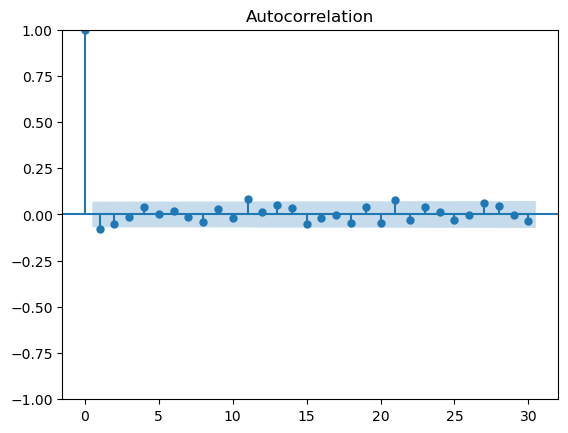

In [57]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(coffee_price)

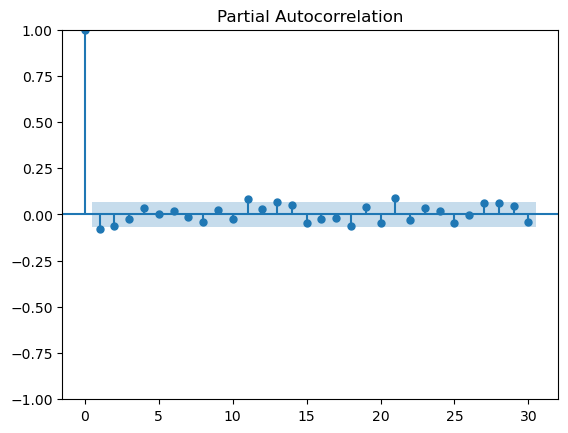

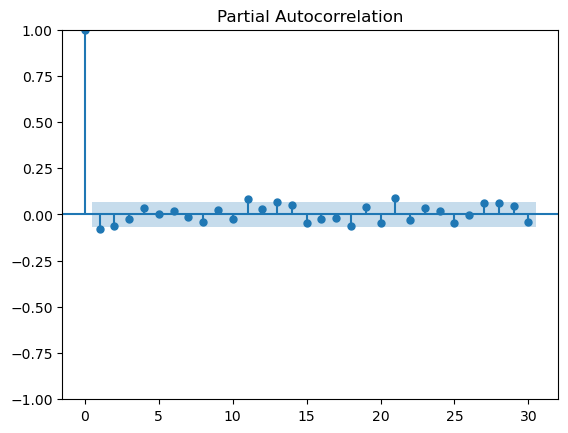

In [58]:
plot_pacf(coffee_price)

Day là mô hình SARIMA(p=3, d=1, q=0)(p=2, D=1, q=1, m=12). Mô hình cho kết quả khá tốt khi các hệ số hồi qui đều có ý nghĩa thống kê (toàn bộ cột P>|z| đều nhỏ hơn 0.05).

In [59]:
# Exogenous features 

In [60]:
exog_features = training[['scaled_diesel_price', 'scaled_precipitation', 'scaled_temp']]

###Make sure the indices of the 'training' and 'exog_features' dataframes are aligned
exog_features = exog_features.reindex(training.index)

In [61]:
exog_features

,scaled_diesel_price,scaled_precipitation,scaled_temp
Ngày,,,
2021-01-01,-1.670519,0.000000,1.124032
2021-01-02,-1.670519,0.000000,1.124032
2021-01-03,-1.670519,0.000000,1.124032
2021-01-04,-1.670519,0.000000,1.124032
2021-01-05,-1.670519,0.000000,1.124032
...,...,...,...
2023-03-06,0.149767,0.679365,-1.083780
2023-03-07,0.149767,0.679365,-1.083780
2023-03-08,0.149767,0.679365,-1.083780


In [62]:
model_sarima = auto_arima(training['r_coffee_price'], 
                          exogenous=exog_features, 
                          start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

print(model_sarima.aic())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=2.28 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-3874.768, Time=0.43 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-4378.562, Time=3.55 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=3.53 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-4140.963, Time=0.22 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-4488.273, Time=3.64 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=7.34 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.48 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-4237.086, Time=1.53 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-4580.661, Time=3.85 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-4473.800, Time=1.50 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=9.06 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=3.92 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-4651.067, Time=7.17 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AI

In [63]:
model_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  798
Model:             SARIMAX(5, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood                2477.489
Date:                                 Wed, 20 Sep 2023   AIC                          -4932.978
Time:                                         15:15:13   BIC                          -4881.655
Sample:                                              0   HQIC                         -4913.245
                                                 - 798                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2565      0.066     -3.886      0.000      -0.386      -0.127
ar.L2         -0.2005      0.067     -2.985      0.003      -0.332      -0.069
ar.L3         -0.1737      0.058     -2.973      0.003      -0.288      -0.059
ar.L4         -0.0927      0.055     -1.698      0.090      -0.200       0.014
ar.L5         -0.0971      0.046     -2.108      0.035      -0.187      -0.007
ma.L1         -0.7646      0.064    -12.009      0.000      -0.889      -0.640
ar.S.L12      -0.6403      0.393     -1.629      0.103      -1.411       0.130
ar.S.L24      -0.0695      0.044     -1.591      0.112      -0.155       0.016
ma.S.L12      -0.2702      0.397     -0.680      0.496      -1.049       0.508
ma.S.L24      -0.5298      0.354     -1.496      0.135      -1.224       0.164
sigma2         0.0001   3.52e-06     30.458      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               737.74
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                             0.50
Prob(H) (two-sided):                  0.03   Kurtosis:                         7.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [64]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Fit SARIMA model and make predictions
def fit_sarima_model(train_data, order, seasonal_order):
    model = SARIMAX(train_data, exog=exog_features, order=order, seasonal_order=seasonal_order, enforce_stationarity=False,
                    enforce_invertibility=False)
    fitted_model = model.fit(disp=-1)
    return fitted_model

# Forecast coffee prices
def forecast_sarima(model, steps, exog=None):
    forecast = model.forecast(steps=steps, exog=exog)
    return forecast


In [67]:
# Best SARIMA parameters obtained from auto_arima
best_sarima_order = (5, 1, 1)
best_seasonal_order = (2, 1, 2, 12)

In [68]:
# Fit the SARIMA model
sarima_model = fit_sarima_model(training['r_coffee_price'], best_sarima_order, best_seasonal_order)

In [69]:
# Forecast future values for the next 1 month (31 days)
forecast_steps = 31

# Get the last available exogenous values for forecasting
last_exog_values = exog_features.tail(1)

# Create a dataframe with the appropriate shape for the forecasted period
forecast_exog = pd.DataFrame(np.tile(last_exog_values.values, (forecast_steps, 1)), columns=last_exog_values.columns)

# Reindex the forecast_exog dataframe to match the forecast period
forecast_exog.index = pd.date_range(start=last_exog_values.index[-1], periods=forecast_steps, freq='D')

In [71]:
forecast_exog

,scaled_diesel_price,scaled_precipitation,scaled_temp
2023-03-10,0.149767,0.679365,-1.08378
2023-03-11,0.149767,0.679365,-1.08378
2023-03-12,0.149767,0.679365,-1.08378
2023-03-13,0.149767,0.679365,-1.08378
2023-03-14,0.149767,0.679365,-1.08378
2023-03-15,0.149767,0.679365,-1.08378
2023-03-16,0.149767,0.679365,-1.08378
2023-03-17,0.149767,0.679365,-1.08378
2023-03-18,0.149767,0.679365,-1.08378
2023-03-19,0.149767,0.679365,-1.08378


In [82]:
testing

,r_coffee_price,scaled_diesel_price,scaled_precipitation,scaled_temp
Ngày,,,,
2023-03-11,0.000000,0.149767,0.679365,-1.08378
2023-03-12,0.000000,0.149767,0.679365,-1.08378
2023-03-13,-0.008409,0.149767,0.679365,-1.08378
2023-03-14,-0.009546,-0.128139,0.679365,-1.08378
2023-03-15,-0.007488,-0.128139,0.679365,-1.08378
2023-03-16,0.003216,-0.128139,0.679365,-1.08378
2023-03-17,-0.003216,-0.128139,0.679365,-1.08378
2023-03-18,0.000000,-0.128139,0.679365,-1.08378
2023-03-19,0.000000,-0.128139,0.679365,-1.08378


In [72]:
# Forecast coffee prices for the next 31 days (Test set) with the forecast_exog values
forecast_test = forecast_sarima(sarima_model, steps=forecast_steps, exog=forecast_exog)

# Convert forecast_test to pandas Series with the correct index
forecast_test_series = pd.Series(forecast_test)
forecast_test_series.index = pd.date_range(start=testing.index[0], periods=forecast_steps, freq='D')  # Adjusted index

# Print the forecasted prices for the next 31 days (Test set)
print("Forecasted Coffee Prices for the Next 31 Days (Test Set):")
print(forecast_test_series)


Forecasted Coffee Prices for the Next 31 Days (Test Set):
2023-03-11    0.000083
2023-03-12    0.000144
2023-03-13    0.000527
2023-03-14    0.000926
2023-03-15    0.001721
2023-03-16    0.000194
2023-03-17    0.001847
2023-03-18    0.000505
2023-03-19   -0.001567
2023-03-20    0.001510
2023-03-21    0.000345
2023-03-22   -0.000430
2023-03-23    0.000057
2023-03-24    0.000046
2023-03-25    0.000367
2023-03-26    0.000703
2023-03-27    0.001372
2023-03-28    0.000313
2023-03-29    0.001868
2023-03-30    0.000612
2023-03-31   -0.001494
2023-04-01    0.001397
2023-04-02    0.000185
2023-04-03   -0.000529
2023-04-04   -0.000127
2023-04-05    0.000017
2023-04-06    0.000284
2023-04-07    0.000662
2023-04-08    0.001287
2023-04-09    0.000091
2023-04-10    0.001696
Freq: D, Name: predicted_mean, dtype: float64


In [73]:
testing

,r_coffee_price,scaled_diesel_price,scaled_precipitation,scaled_temp
Ngày,,,,
2023-03-11,0.000000,0.149767,0.679365,-1.08378
2023-03-12,0.000000,0.149767,0.679365,-1.08378
2023-03-13,-0.008409,0.149767,0.679365,-1.08378
2023-03-14,-0.009546,-0.128139,0.679365,-1.08378
2023-03-15,-0.007488,-0.128139,0.679365,-1.08378
2023-03-16,0.003216,-0.128139,0.679365,-1.08378
2023-03-17,-0.003216,-0.128139,0.679365,-1.08378
2023-03-18,0.000000,-0.128139,0.679365,-1.08378
2023-03-19,0.000000,-0.128139,0.679365,-1.08378


In [74]:
# Convert the logarithmic returns back to normal prices
previous_price = data_df['Giá Cà Phê'].shift(1)  # Previous prices
predicted_price = previous_price * np.exp(forecast_test_series)    # Calculated predicted prices

# create a new column in the DataFrame for the predicted prices
data_df['Predicted_Price'] = predicted_price

In [75]:
data_df

,Giá Cà Phê,Giá Diesel 1 lít,Precipitation (mm),Temperature (°C),Predicted_Price
Ngày,,,,,
2021-01-01,31667.5,12640,1174.199994,24.937842,NaN
2021-01-02,31667.5,12640,1174.199994,24.937842,NaN
2021-01-03,31667.5,12640,1174.199994,24.937842,NaN
2021-01-04,32717.0,12640,1174.199994,24.937842,NaN
2021-01-05,32417.0,12640,1174.199994,24.937842,NaN
...,...,...,...,...,...
2023-04-06,49766.5,20140,1259.800013,24.170057,49480.541646
2023-04-07,49566.5,20140,1259.800013,24.170057,49799.450385
2023-04-08,49566.5,20140,1259.800013,24.170057,49630.352728


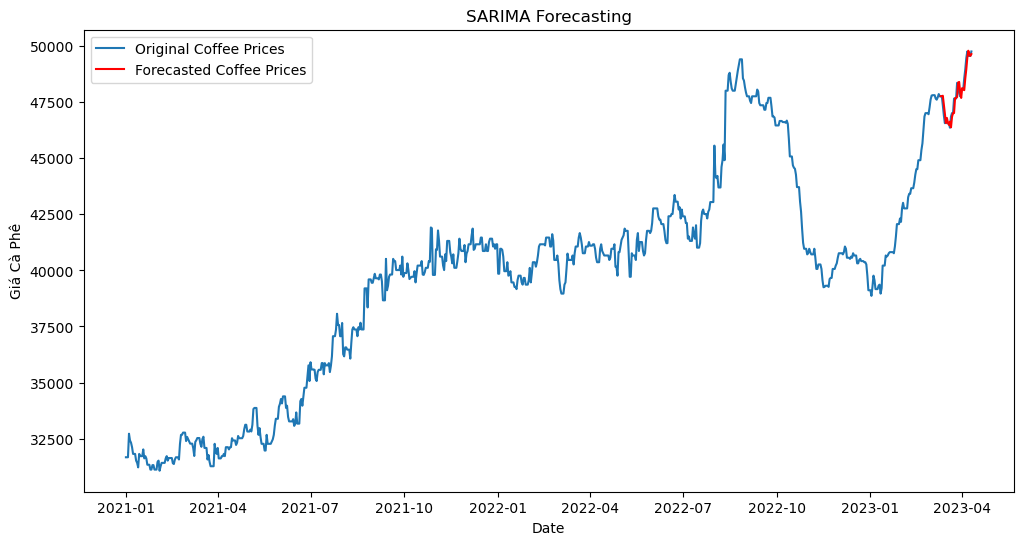

In [76]:
# Plot the original data and forecasted coffee prices
plt.figure(figsize=(12, 6))
plt.plot(data_df.index, data_df['Giá Cà Phê'], label='Original Coffee Prices')
plt.plot(data_df.index, data_df['Predicted_Price'], color='red', label='Forecasted Coffee Prices')
plt.xlabel('Date')
plt.ylabel('Giá Cà Phê')
plt.title('SARIMA Forecasting')
plt.legend()
plt.show()

In [77]:
predicted = data_df['Predicted_Price'].iloc[-31:]

In [78]:
predicted

Ngày
2023-03-11    47770.487707
2023-03-12    47773.357349
2023-03-13    47791.668121
2023-03-14    47410.361302
2023-03-15    46997.310014
2023-03-16    46575.517177
2023-03-17    46802.845418
2023-03-18    46590.040413
2023-03-19    46493.601590
2023-03-20    46636.885706
2023-03-21    46382.480531
2023-03-22    46846.343933
2023-03-23    47019.197613
2023-03-24    47018.667698
2023-03-25    47683.975290
2023-03-26    47700.039587
2023-03-27    47731.957027
2023-03-28    48381.640981
2023-03-29    48406.854930
2023-03-30    47945.822798
2023-03-31    47695.192744
2023-04-01    48133.717486
2023-04-02    48075.376454
2023-04-03    48041.057476
2023-04-04    48560.339368
2023-04-05    48967.334849
2023-04-06    49480.541646
2023-04-07    49799.450385
2023-04-08    49630.352728
2023-04-09    49571.021343
2023-04-10    49650.621467
Name: Predicted_Price, dtype: float64

In [79]:
actual = data_df['Giá Cà Phê'].iloc[-31:]

In [80]:
actual

Ngày
2023-03-11    47766.5
2023-03-12    47766.5
2023-03-13    47366.5
2023-03-14    46916.5
2023-03-15    46566.5
2023-03-16    46716.5
2023-03-17    46566.5
2023-03-18    46566.5
2023-03-19    46566.5
2023-03-20    46366.5
2023-03-21    46866.5
2023-03-22    47016.5
2023-03-23    47016.5
2023-03-24    47666.5
2023-03-25    47666.5
2023-03-26    47666.5
2023-03-27    48366.5
2023-03-28    48316.5
2023-03-29    47916.5
2023-03-30    47766.5
2023-03-31    48066.5
2023-04-01    48066.5
2023-04-02    48066.5
2023-04-03    48566.5
2023-04-04    48966.5
2023-04-05    49466.5
2023-04-06    49766.5
2023-04-07    49566.5
2023-04-08    49566.5
2023-04-09    49566.5
2023-04-10    49766.5
Name: Giá Cà Phê, dtype: float64

In [81]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def calculate_metrics(actual_prices, predicted_prices):
    mse = mean_squared_error(actual_prices, predicted_prices)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_prices, predicted_prices)
    mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100
    
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("Mean Absolute Error (MAE):", mae)
    print("Mean Absolute Percentage Error (MAPE):", mape)


calculate_metrics(actual, predicted)


Mean Squared Error (MSE): 100488.25333515754
Root Mean Squared Error (RMSE): 316.99882229301346
Mean Absolute Error (MAE): 239.07258455903315
Mean Absolute Percentage Error (MAPE): 0.49923779821575204
